## Evaluation of the Recommender System

### Our chatbot provides the user with three recommendations. Here, we evaluate the recommender system; in particular, the relevance and coverage of the recommendations provided. We do so using some of the user rating data that was held out. 

In [2]:
from movie_recommender import movies_similar_to
import numpy as np
import pandas as pd
import pickle 

with open('G:/My Drive/DublinAI/Mini Projects/chatbot/nn/embeddings_smaller', 'rb') as file:
    embed, movie_to_index = pickle.load(file)

df = pd.read_csv('./the-movies-dataset/df_prep.csv',low_memory=False)

# A bit of munging.. 
#ratings_training = pd.read_csv('G:/My Drive/DublinAI/Mini Projects/chatbot/the-movies-dataset/ratings.csv',low_memory=False)
#ratings_val = pd.read_csv('G:/My Drive/DublinAI/Mini Projects/chatbot/extra_data/ml-latest/ratings_more.csv',low_memory=False)
#
## The two datasets may use different ways of indexing users? 
## But if movieId+rating+timestamp match, likely to be a duplicate
#tr_copy = ratings_training.drop(['userId'],axis=1)
#val_copy = ratings_val.drop(['userId'],axis=1)
#merged = pd.concat([val_copy, tr_copy]).drop_duplicates(keep=False)
#remainder_val_idx = np.asarray(merged.index[merged.index<val_copy.shape[0]])
#
#ratings_small = ratings_val.iloc[remainder_val_idx]
#ratings_small['newId'] = ratings_small['movieId'].map(movie_to_index)
#ratings_small = ratings_small.dropna(subset=['newId'])
#
## Check to make sure movies in ratings dataset are also in our main database
#to_keep = ratings_small.movieId.apply(lambda x: x in df['movieId'])
#ratings_small=ratings_small[to_keep]
#ratings_small.shape
#ratings_small.to_csv('validation_data.csv')

### Precision @ k (k=3 in this case) is a measure of the number of relevant recommendations in the top k items recommended. Our input to the system is a movie that the user has watched and liked. We define a recommendation to be 'relevant' if it was indeed subsequently watched by the user. Precision allows us to gauge the accuracy of our system. Users are likely to be happy with the recommendation if it is relevant. 

### However, focusing on accuracy alone could be suboptimal. We also want to provide users with interesting recommendations -- items they may not have come across themselves. We compute another measure here -- coverage -- to gauge the diversity of recommended items. 

In [ ]:
ratings_small = pd.read_csv('validation_data.csv')
n_users = ratings_small.userId.value_counts().shape[0]
print(str(ratings_small.shape[0]) + ' ratings by ' + str(n_users) + ' users')

#%%# how likely is a suggested movie to be one that the user actually watched and liked?
# recommend k movies most similar to the first n movies that the user liked
# find overlap with the movies that the user subsequently watched and liked
def precision_recall_coverage_k(ratings, n_train, k=5):
    n_positive = ratings[ratings.rating>3].userId.value_counts()
    unique_users = np.asarray(n_positive[n_positive>(n_train+k)].index)
    potential_movies = ratings[ratings.rating>3].movieId.unique().shape[0]
    n_users = unique_users.shape[0]
    precision = np.zeros((n_users,1))
    recall=np.zeros((n_users,1))
    all_predictions = []
    print('Sufficient data found for ' + str(n_users) + ' users')
    for i in range(n_users):
        if i%1000==0:
            print('Computing p & r for user: ' + str(i))
        #indices = list(ratings.index[ratings.userId == unique_users[i]])
        positive_indices = list(ratings.index[(ratings.userId == unique_users[i]) &  (ratings.rating>3)])        
        v_i = list(map(int,list(ratings.newId[positive_indices[:n_train]])))
        mapped_indices = [int(df.index[df.newId==j][0]) for j in v_i if df.index[df.newId==j].shape[0]>0]
        entity = [0,mapped_indices]
        _, ids = movies_similar_to(entity,k,genre='all',method = 'collab',exclude_collection = False)
        predicted_films = set(np.asarray(df.newId[ids]))
        all_predictions = all_predictions + list(predicted_films)
        #x = np.where(np.asarray(indices) == positive_indices[n_train])
        #ground_truth =  set(ratings.newId[indices[x[0][0]:]])
        ground_truth =  set(ratings.newId[positive_indices[n_train:]])
        precision[i] = len(list(predicted_films.intersection(ground_truth)))/k
        recall[i] = len(list(predicted_films.intersection(ground_truth)))/len(ground_truth)
# current movie rating = distance of current movie from n-1
    coverage = len(set(all_predictions))/potential_movies
    return unique_users, precision, recall, coverage

unique_users, precision, recall, coverage = precision_recall_coverage_k(ratings_small,1,k=3)

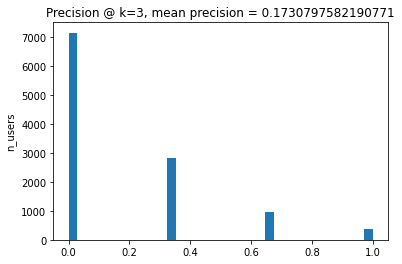

Coverage = 0.5173305742369374


In [5]:
import matplotlib.pyplot as plt
plt.hist(precision, bins='auto')
plt.title("Precision @ k=3, mean precision = " + str(np.mean(precision)))
plt.ylabel("n_users")
plt.show()
print('Coverage = ' + str(coverage))

### What do these numbers mean? To get a better feel, we compare them with what with would get if we had (1) simply selected any 3 random movies for the user, (2) always recommended the same 3 movies which have the highest average rating across users, and (3) always recommended the same 3 most popular movies according to imdb users (different dataset)

In [ ]:
# For comparison, we select k random movies for the user
from random import randint
def precision_recall_coverage_k_random(ratings, k=5):
    n_positive = ratings[ratings.rating>3].userId.value_counts()
    unique_users = np.asarray(n_positive[n_positive>k].index)
    potential_movies = ratings[ratings.rating>3].movieId.unique().shape[0]
    n_users = unique_users.shape[0]
    precision = np.zeros((n_users,1))
    recall=np.zeros((n_users,1))
    all_predictions = []
    print('Sufficient data found for ' + str(n_users) + ' users')
    for i in range(n_users):
        if i%1000==0:
            print('Computing p & r for user: ' + str(i))
        #indices = list(ratings.index[ratings.userId == unique_users[i]])
        indices = list(ratings.index[(ratings.userId == unique_users[i]) &  (ratings.rating>3)]) 
        ids = [randint(0,df.shape[0]-1) for j in range(k)]
        predicted_films = set(np.asarray(df.newId[ids]))
        all_predictions = all_predictions + list(predicted_films)
        ground_truth =  set(ratings.newId[indices])
        precision[i] = len(list(predicted_films.intersection(ground_truth)))/k
        recall[i] = len(list(predicted_films.intersection(ground_truth)))/len(ground_truth)
# current movie rating = distance of current movie from n-1
    coverage = len(set(all_predictions))/potential_movies
    print('number of potential movies: ' + str(potential_movies))
    return unique_users, precision, recall, coverage

unique_users_rand, precision_rand, recall_rand, coverage_rand = precision_recall_coverage_k_random(ratings_small,k=3)


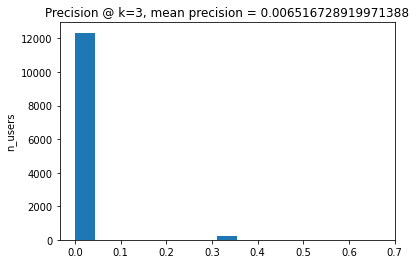

Coverage = 1.932229694774961


In [9]:
plt.hist(precision_rand, bins='auto')
plt.title("Precision @ k=3, mean precision = " + str(np.mean(precision_rand)))
plt.ylabel("n_users")
plt.show()
print('Coverage = ' + str(coverage_rand))

In [ ]:
# Another comparison - sort metadata by vote_average, pick the top k
df_sorted = df.sort_values(by=['vote_average'],ascending=False)

def precision_recall_k_best_ave(ratings, k=5):
    n_positive = ratings[ratings.rating>3].userId.value_counts()
    unique_users = np.asarray(n_positive[n_positive>k].index)
    n_users = unique_users.shape[0]
    precision = np.zeros((n_users,1))
    recall=np.zeros((n_users,1))
    ids = list(df_sorted.index[:k])
    print('Sufficient data found for ' + str(n_users) + ' users')
    for i in range(n_users):
        if i%1000==0:
            print('Computing p & r for user: ' + str(i))
        #indices = list(ratings.index[ratings.userId == unique_users[i]])
        indices = list(ratings.index[(ratings.userId == unique_users[i]) &  (ratings.rating>3)]) 
        predicted_films = set(np.asarray(df.newId[ids]))
        ground_truth =  set(ratings.newId[indices])
        precision[i] = len(list(predicted_films.intersection(ground_truth)))/k
        recall[i] = len(list(predicted_films.intersection(ground_truth)))/len(ground_truth)
# current movie rating = distance of current movie from n-1
    return unique_users, precision, recall

unique_users_best_ave, precision_best_ave, recall_best_ave = precision_recall_k_best_ave(ratings_small,k=3)

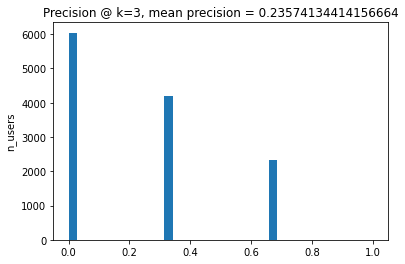

Coverage = 0.0015519917227108122


In [11]:
plt.hist(precision_best_ave, bins='auto')
plt.title("Precision @ k=3, mean precision = " + str(np.mean(precision_best_ave)))
plt.ylabel("n_users")
plt.show()
print('Coverage = ' + str(3/1933))

In [ ]:
# Another comparison - sort metadata by popularity, pick the top k
df_sorted = df.sort_values(by=['popularity'],ascending=False)

def precision_recall_k_best_pop(ratings, k=5):
    n_positive = ratings[ratings.rating>3].userId.value_counts()
    unique_users = np.asarray(n_positive[n_positive>k].index)
    n_users = unique_users.shape[0]
    precision = np.zeros((n_users,1))
    recall=np.zeros((n_users,1))
    ids = list(df_sorted.index[:k])
    print('Sufficient data found for ' + str(n_users) + ' users')
    for i in range(n_users):
        if i%1000==0:
            print('Computing p & r for user: ' + str(i))
        indices = list(ratings.index[ratings.userId == unique_users[i]])
        predicted_films = set(np.asarray(df.newId[ids]))
        ground_truth =  set(ratings.newId[indices])
        precision[i] = len(list(predicted_films.intersection(ground_truth)))/k
        recall[i] = len(list(predicted_films.intersection(ground_truth)))/len(ground_truth)
# current movie rating = distance of current movie from n-1
    return unique_users, precision, recall

unique_users_best_pop, precision_best_pop, recall_best_pop = precision_recall_k_best_pop(ratings_small,k=3)


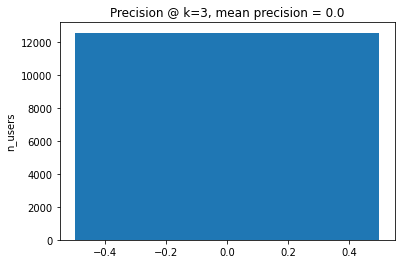

In [13]:
plt.hist(precision_best_pop, bins='auto')
plt.title("Precision @ k=3, mean precision = " + str(np.mean(precision_best_pop)))
plt.ylabel("n_users")
plt.show()

### To summarise, we find that our system is less precise than if we were to simply recommended the top movies in terms of average user rating. However, our coverage (diversity of recommendations) in that case would be very low -- customers would soon get bored. We could get higher coverage if we randomly recommended movies to users, but the relevance of our recommendations in that case is low -- this could frustrate customers. Our system therefore strikes a balance between the two extremes. 
